# Solving QUBO/Ising Problems via Unit-Disk Graphs on Neutral Atom Quantum Computers

### Install dependencies

In [1]:
# !pip install bloqade-analog

## Formulating the Problem Hamiltonian
In the following part, we demonstrate how to use the `Jijmodleing` to fomulate the problem Hamiltonian.

In [2]:
import numpy as np
import jijmodeling as jm
import jijmodeling_transpiler.core as jmt


def QUBO_problem():
    # --- placeholders ---
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    U = jm.Placeholder("U", ndim=2)

    n = jm.BinaryVar("n", shape=(V,))
    e = jm.Element("e", belong_to=E)

    # --- build problem ---
    problem = jm.Problem("QUBO_Hamiltonian")

    quadratic_term = jm.sum(e, U[e[0], e[1]] * n[e[0]] * n[e[1]])
    problem += quadratic_term
    return problem


problem = QUBO_problem()
problem

In [3]:
import numpy as np

quad = {
    (0, 0): -1.2,
    (1, 1): -3.2,
    (2, 2): -1.2,
    (0, 1): 4.0,
    (0, 2): -2.0,
    (1, 2): 3.2,
}

V_val = 3
E_val = np.array(list(quad.keys()), dtype=int)
U_val = np.zeros((V_val, V_val))
for (i, j), Jij in quad.items():
    U_val[i, j] = U_val[j, i] = Jij

instance = {
    "V": V_val,
    "E": E_val,
    "U": U_val,
}

compiled_instance = jmt.compile_model(problem, instance)

### Converting the Problem with `qamomile`

Once, we obtain the `compiled_instance`, the `QuantumConverter` can convert it to the `IsingModel` class.

In [5]:
from qamomile.core.converters.qaoa import QAOAConverter

udm_converter = QAOAConverter(compiled_instance)
ising_model = udm_converter.ising_encode()
ising_model

IsingModel(quad={(0, 1): 1.0, (0, 2): -0.5, (1, 2): 0.8}, linear={0: 0.09999999999999998, 1: -0.19999999999999996, 2: 0.30000000000000004}, constant=-1.5000000000000002, index_map=None)

## Unit-Disk Mapping with `qamomile`

### Performing the Mapping: `UnitDiskGraph` Class

The `UnitDiskGraph` class handles the conversion from an `IsingModel` to the UDG representation.

In [6]:
from qamomile.udm import Ising_UnitDiskGraph

udg = Ising_UnitDiskGraph(ising_model)

print(f"Converted to Unit Disk Graph:")
print(f"- {len(udg.nodes)} nodes in the grid graph")
print(f"- {len(udg.pins)} pins (nodes corresponding to original variables)")

Overwriting delta from 2.7 to 1.5
Converted to Unit Disk Graph:
- 26 nodes in the grid graph
- 3 pins (nodes corresponding to original variables)


### Visualizing the UDG

We can visualize the resulting UDG structure using `networkx` and `matplotlib`. The `UnitDiskGraph` object provides access to the underlying graph structure. This visualization helps understand how the abstract Ising problem is physically laid out using the UDM gadgets.

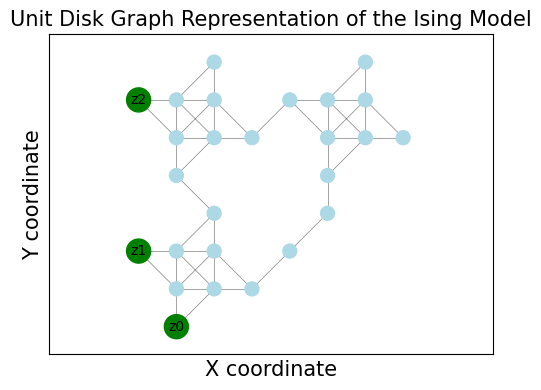

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

G_vis = udg.networkx_graph
pos = nx.get_node_attributes(G_vis, "pos")
pins = udg.pins
plt.figure(figsize=(5, 4))

# Highlight pins (original variables)
node_colors = ["Green" if i in pins else "lightblue" for i in G_vis.nodes()]
node_sizes = [300 if i in pins else 100 for i in G_vis.nodes()]

nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G_vis, pos, width=0.5, alpha=0.5)

# Label the pins with their original variable index
pin_labels = {pin: f"z{i}" for i, pin in enumerate(pins)}  # Use z_i for Ising spins
nx.draw_networkx_labels(G_vis, pos, labels=pin_labels, font_size=10)

plt.title("Unit Disk Graph Representation of the Ising Model", fontsize=15)
plt.xlabel("X coordinate", fontsize=15)
plt.ylabel("Y coordinate", fontsize=15)
plt.axis("equal")  # Ensure aspect ratio is maintained
plt.tight_layout()
plt.show()

## Solving MWIS-UDG with **`bloqade-analog`**

Now that we have mapped the original Ising problem to an MWIS problem on a Unit-Disk Graph, we can leverage the native capabilities of neutral atom quantum computers to find the solution.

### Implementation with **`bloqade-analog`**

`bloqade-analog` is a Python library for simulating analog neutral atom quantum computations, particularly suited for adiabatic protocols like the one described above. The `bloqade_example.py` script shows how to use it with our UDG mapping.

**Steps:**

1.  **Prepare Inputs:**
    *   Get atom locations from the `UnitDiskGraph` object (`udg.nodes`). These locations need to be scaled to physical units (e.g., micrometers) appropriate for typical blockade radii.
    *   Get node weights (`udg.nodes[i].weight`). These weights are typically normalized.
    *   Define the pulse parameters: maximum Rabi frequency `Omega_max`, maximum detuning `delta_max`, and total evolution time `t_max`.

In [8]:
import numpy as np
import math

LOCATION_SCALE = 5.0  # Adjust based on desired blockade radius and hardware

locations = udg.qubo_result.qubo_grid_to_locations(LOCATION_SCALE)
weights = udg.qubo_result.qubo_result_to_weights()

print(f"Node weights: {weights}")
print(f"Node locations: {locations}")

Node weights: [1.3, 1.8, 1.6, 5.0, 7.0, 3.0, 6.5, 5.5, 7.0, 5.0, 3.0, 5.5, 6.5, 1.4, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.2, 6.8, 6.8, 5.2, 1.7, 1.2]
Node locations: [(0.0, 10.0), (0.0, 30.0), (5.0, 0.0), (5.0, 5.0), (5.0, 10.0), (5.0, 20.0), (5.0, 25.0), (5.0, 30.0), (10.0, 5.0), (10.0, 10.0), (10.0, 15.0), (10.0, 25.0), (10.0, 30.0), (10.0, 35.0), (15.0, 5.0), (15.0, 25.0), (20.0, 10.0), (20.0, 30.0), (25.0, 15.0), (25.0, 20.0), (25.0, 25.0), (25.0, 30.0), (30.0, 25.0), (30.0, 30.0), (30.0, 35.0), (35.0, 25.0)]


2.  **Define the Program:** Use `bloqade.analog` to define the atom geometry and pulse sequence.

In [9]:
from bloqade.analog import start


def solve_ising_bloqade(locations, weights, delta_max=60.0, Omega_max=15.0, t_max=4.0):
    locations_array = np.array(locations)
    centroid = locations_array.mean(axis=0)
    centered_locations = locations_array - centroid
    locations = list(map(tuple, centered_locations))

    lw = len(weights)
    weights_norm = [x / max(weights) for x in weights]

    def sine_waveform(t):
        return Omega_max * math.sin(math.pi * t / t_max) ** 2

    def linear_detune_waveform(t):
        return delta_max * (2 * t / t_max - 1)

    program = (
        start.add_position(locations)
        .rydberg.detuning.scale(weights_norm)
        .fn(linear_detune_waveform, t_max)
        .amplitude.uniform.fn(sine_waveform, t_max)
    )

    return program


program = solve_ising_bloqade(locations, weights)

3.  **Run the Simulation:** Execute the program using Bloqade's emulator.

In [10]:
blockade_radius = (
    LOCATION_SCALE * 1.5
)  # blockade radius is set to cover the diagonoal node (1: sqrt(2))
emu_results = program.bloqade.python().run(
    shots=10000, solver_name="dop853", blockade_radius=blockade_radius
)

report = emu_results.report()
counts = report.counts()[0]

sorted_counts = {
    k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)
}

print("\nBloqade Simulation Results (Top 5):")
for i, (bitstring, count) in enumerate(list(sorted_counts.items())[:5]):
    print(f" {i+1}. Bitstring: {bitstring} (Count: {count})")


Bloqade Simulation Results (Top 5):
 1. Bitstring: 10010011111101011001110101 (Count: 703)
 2. Bitstring: 10010011111101011101101110 (Count: 298)
 3. Bitstring: 11010101111110011001110101 (Count: 291)
 4. Bitstring: 11010101111110001101101110 (Count: 286)
 5. Bitstring: 10110011111101011001110101 (Count: 285)


### Visualizing the result from Bloqade's emulator.

We can visualize the result from Bloqade's emulator. The red node shows the mapping of the `Bitstring`.

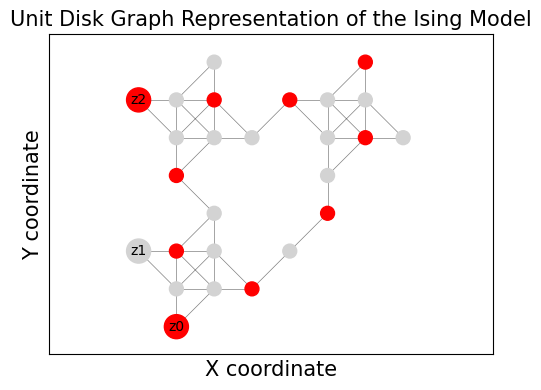

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

G_vis = udg.networkx_graph
pos = nx.get_node_attributes(G_vis, "pos")

plt.figure(figsize=(5, 4))

bitstr = list(sorted_counts.items())[:2][0][0]

# Color and size nodes based on bit value
node_colors = ["red" if b == "0" else "lightgray" for b in bitstr]
node_sizes = [300 if i in pins else 100 for i in G_vis.nodes()]

nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G_vis, pos, width=0.5, alpha=0.5)

# Label the pins with their original variable index
pin_labels = {pin: f"z{i}" for i, pin in enumerate(pins)}  # Use z_i for Ising spins
nx.draw_networkx_labels(G_vis, pos, labels=pin_labels, font_size=10)

plt.title("Unit Disk Graph Representation of the Ising Model", fontsize=15)
plt.xlabel("X coordinate", fontsize=15)
plt.ylabel("Y coordinate", fontsize=15)
plt.axis("equal")  # Ensure aspect ratio is maintained
plt.tight_layout()
plt.show()

### Converting the Bloqade's emulator result to `sampleset` result.

From the emulator result obtained earlier, we can transfer them to a sampleset by `udm_converter.decode`. The `sampleset` can examine the distribution of the objective function values.

In [12]:
from qamomile.udm.transpiler import UDMTranspiler

transpiler = UDMTranspiler(udg, V_val)
sampleset = udm_converter.decode(transpiler, counts)

### Check the lowest solution

In [13]:
sampleset.lowest()

[Sample(run_id="0f45e0fa-bfd0-408f-856f-d76ad80e5f78", num_occurrences=2181, run_info={}, var_values={"n": SparseVarValues(name="n", values={(0,): 1, (2,): 1}, shape=(3,), var_type=VarType.CONTINUOUS)}, eval=EvaluationResult(objective=-4.4, constraints={}, penalties={}))]

### Check the classcical method

In [14]:
import numpy as np
from itertools import product

Q = np.array([[-1.2, 4.0, -2.0], [4.0, -3.2, 3.2], [-2.0, 3.2, -1.2]])


def Solve_Q(Q: np.ndarray, x: np.ndarray) -> float:
    E = np.dot(np.diag(Q), x)
    n = len(x)
    for i in range(n):
        for j in range(i + 1, n):
            E += Q[i, j] * x[i] * x[j]
    return E


energies = {}
for bits in product([0, 1], repeat=3):
    x = np.array(bits)
    energy = Solve_Q(Q, x)
    energies[bits] = energy
min_config, min_energy = min(energies.items(), key=lambda item: item[1])
print("min_config: ", min_config)
print("min_energy: ", min_energy)

min_config:  (1, 0, 1)
min_energy:  -4.4


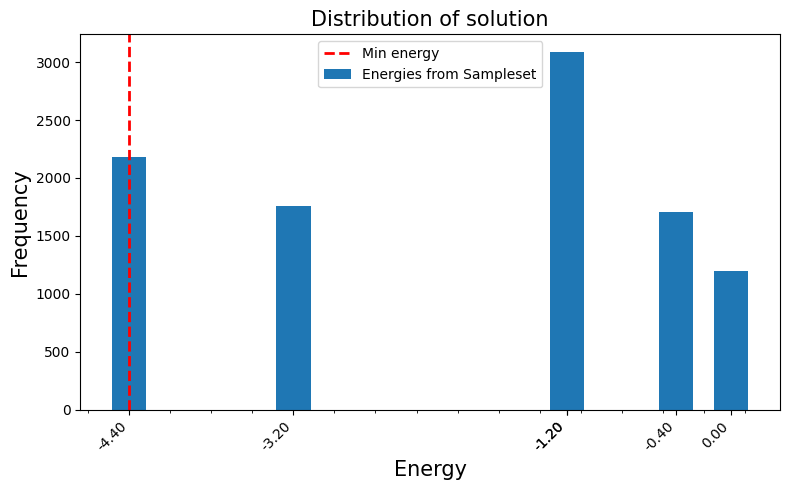

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter

plot_data = {}
for sample in sampleset:
    if sample.eval.objective in plot_data:
        plot_data[sample.eval.objective] += sample.num_occurrences
    else:
        plot_data[sample.eval.objective] = sample.num_occurrences

energies = sorted(plot_data.keys())
freqs = [plot_data[e] for e in energies]
plt.figure(figsize=(8, 5))
plt.bar(energies, freqs, width=0.25, label="Energies from Sampleset")

ax = plt.gca()
ax.set_xticks(energies)
ax.set_xticklabels([f"{e:.2f}" for e in energies], rotation=45, ha="right")
ax.axvline(min_energy, color="red", linestyle="--", linewidth=2, label="Min energy")

ax.xaxis.set_minor_locator(AutoMinorLocator(4))

plt.title("Distribution of solution", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.legend(loc="upper center")
plt.tight_layout()
plt.show()